In [9]:
import smash
from smash.solver._mwd_cost import nse
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from preprocessing import load_data

In [2]:
smash.__version__

'0.4.2'

## 1. Calibration Period

In [3]:
def df_cost(area):
    
    modelddt_unif = smash.read_model_ddt(f"models/{area}/uniform.hdf5")
    modelddt_ln = smash.read_model_ddt(f"models/{area}/hyper-linear.hdf5")
    modelddt_pl = smash.read_model_ddt(f"models/{area}/hyper-polynomial.hdf5")
    modelddt_ann = smash.read_model_ddt(f"models/{area}/ann.hdf5")

    gau = pd.read_csv(f"data/{area}/cal_code.csv")["cal"].to_list()
    ung = pd.read_csv(f"data/{area}/val_code.csv")["val"].to_list()

    code = []
    obs = []
    method = []
    cost = []

    for i, co in enumerate(modelddt_unif["code"]):

        if co in gau+ung:

            code += [co] * 5
            if co in gau:
                obs += [f"{area} Gauged ({len(gau)})"] * 5
            else:
                obs += [f"{area} Ungauged ({len(ung)})"] * 5
            
            # local unif
            method.append("Uniform (local)")
            cost.append(1 - smash.read_model_ddt(f"models/{area}/local-uniform/{co}.hdf5")["cal_cost"])

            # global unif
            method.append("Uniform (global)")
            cost.append(1 - nse(modelddt_unif["qobs"][i], modelddt_unif["qsim"][i]))

            # linear regio
            method.append("Multi-linear (regionalization)")
            cost.append(1 - nse(modelddt_ln["qobs"][i], modelddt_ln["qsim"][i]))

            # poly regio
            method.append("Multi-polynomial (regionalization)")
            cost.append(1 - nse(modelddt_pl["qobs"][i], modelddt_pl["qsim"][i]))

            # ann regio
            method.append("ANN (regionalization)")
            cost.append(1 - nse(modelddt_ann["qobs"][i], modelddt_ann["qsim"][i]))

    return pd.DataFrame({"code": code, "obs": obs, "method": method, "NSE": cost})

In [4]:
df1 = df_cost("MedEst")
df2 = df_cost("Ardeche")

df = pd.concat([df1, df2], ignore_index=True)

In [41]:
df.head()

,code,obs,method,NSE
0,Y4624010,MedEst Gauged (9),Uniform (local),0.519397
1,Y4624010,MedEst Gauged (9),Uniform (global),0.359392
2,Y4624010,MedEst Gauged (9),Multi-linear (regionalization),0.694059
3,Y4624010,MedEst Gauged (9),Multi-polynomial (regionalization),0.715963
4,Y4624010,MedEst Gauged (9),ANN (regionalization),0.845858


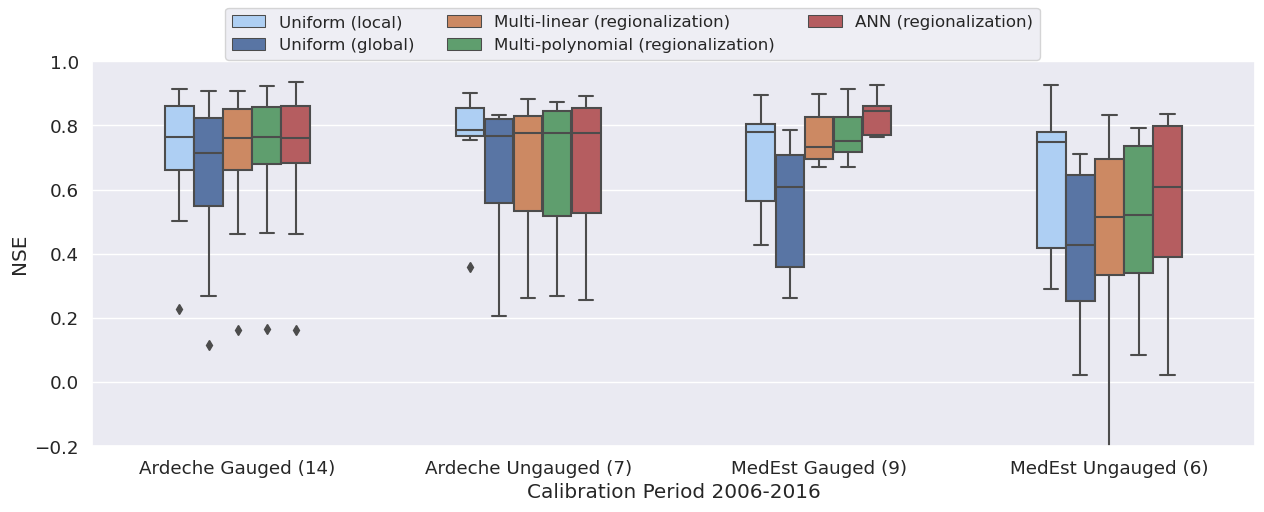

In [42]:
ord = df.obs.unique()
ord.sort()

colors = [
        "#a2cffe",
        # "#fed0fc",
        "#4c72b0",
        "#dd8452",
        "#55a868",
        "#c44e52",
    ]

sns.set(font_scale=1.2)

fig, ax = plt.subplots(figsize=(15,5))

sns.boxplot(
        data=df,
        x="obs",
        y="NSE",
        hue="method",
        width=0.5,
        palette=colors,
        order=ord,
        showfliers=True,
    )


# Set title and axis labels
ax.set(title=None, xlabel="Calibration Period 2006-2016")

ax.set_ylim([-0.2, 1])

handles, labels = ax.get_legend_handles_labels()  # get labels then remove
ax.legend([], [], frameon=False)

# Add legend
fig.legend(
    handles,
    labels,
    title=None,
    loc="upper center",
    ncol=3,
    fontsize=12,
)

## 2. Validation Period

In [36]:
def df_cost_val(area, ncpu=1, start_time="2016-08-01 00:00", end_time="2018-08-01 00:00"):
    
    modelddt_unif = smash.read_model_ddt(f"models/{area}/uniform.hdf5")
    modelddt_ln = smash.read_model_ddt(f"models/{area}/hyper-linear.hdf5")
    modelddt_pl = smash.read_model_ddt(f"models/{area}/hyper-polynomial.hdf5")
    modelddt_ann = smash.read_model_ddt(f"models/{area}/ann.hdf5")

    model = smash.Model(
        *load_data(
            f"data/{area}/info_bv.csv",
            start_time=start_time,
            end_time=end_time,
            desc_dir="...",
        )
    )
    
    params = model.get_bound_constraints(states=False)["names"]
    
    for par in params:
        setattr(model.parameters, par, modelddt_unif[par])
    model_unif = model.run()

    for par in params:
        setattr(model.parameters, par, modelddt_ln[par])
    model_ln = model.run()

    for par in params:
        setattr(model.parameters, par, modelddt_pl[par])
    model_pl = model.run()

    for par in params:
        setattr(model.parameters, par, modelddt_ann[par])
    model_ann = model.run()

    gau = pd.read_csv(f"data/{area}/cal_code.csv")["cal"].to_list()
    ung = pd.read_csv(f"data/{area}/val_code.csv")["val"].to_list()

    code = []
    obs = []
    method = []
    cost = []

    for i, co in enumerate(modelddt_unif["code"]):

        if co in gau+ung:

            code += [co] * 5
            if co in gau:
                obs += [f"{area} Gauged ({len(gau)})"] * 5
            else:
                obs += [f"{area} Ungauged ({len(ung)})"] * 5
            
            # local unif
            method.append("Uniform (local)")
            modelddt_localunif = smash.read_model_ddt(f"models/{area}/local-uniform/{co}.hdf5")
            info_catch = pd.read_csv(f"data/{area}/info_bv.csv")
            model_localunif = smash.Model(
                                *load_data(
                                    info_catch[info_catch.Code_BV==co],
                                    start_time=start_time,
                                    end_time=end_time,
                                    desc_dir="...",
                                )
                            )
            for par in params:
                setattr(model_localunif.parameters, par, modelddt_localunif[par])
            model_localunif.run(inplace=True)
            cost.append(1 - nse(model_localunif.input_data.qobs[0], model_localunif.output.qsim[0]))
    
            # global unif
            method.append("Uniform (global)")
            cost.append(1 - nse(model_unif.input_data.qobs[i], model_unif.output.qsim[i]))

            # linear regio
            method.append("Multi-linear (regionalization)")
            cost.append(1 - nse(model_ln.input_data.qobs[i], model_ln.output.qsim[i]))

            # poly regio
            method.append("Multi-polynomial (regionalization)")
            cost.append(1 - nse(model_pl.input_data.qobs[i], model_pl.output.qsim[i]))

            # ann regio
            method.append("ANN (regionalization)")
            cost.append(1 - nse(model_ann.input_data.qobs[i], model_ann.output.qsim[i]))

    return pd.DataFrame({"code": code, "obs": obs, "method": method, "NSE": cost})

In [37]:
df1val = df_cost_val("MedEst")
df2val = df_cost_val("Ardeche")

dfval = pd.concat([df1val, df2val], ignore_index=True)

</> Reading precipitation:  53%|█████▎    | 9358/17520 [00:03<00:03, 2313.85it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model
</> Run Model
</> Run Model
</> Run Model


</> Reading precipitation:  53%|█████▎    | 9272/17520 [00:01<00:01, 5401.16it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  53%|█████▎    | 9276/17520 [00:01<00:01, 5773.38it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  53%|█████▎    | 9295/17520 [00:01<00:01, 5844.91it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  53%|█████▎    | 9331/17520 [00:01<00:01, 5769.54it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  51%|█████     | 8876/17520 [00:01<00:01, 6827.61it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  54%|█████▎    | 9387/17520 [00:01<00:01, 7321.46it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  52%|█████▏    | 9136/17520 [00:01<00:01, 5340.77it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  53%|█████▎    | 9272/17520 [00:01<00:01, 5833.59it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  53%|█████▎    | 9315/17520 [00:01<00:01, 6306.13it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  52%|█████▏    | 9027/17520 [00:01<00:01, 5667.46it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  53%|█████▎    | 9245/17520 [00:02<00:01, 4340.49it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  53%|█████▎    | 9264/17520 [00:01<00:01, 5419.48it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  52%|█████▏    | 9163/17520 [00:02<00:02, 4111.50it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  54%|█████▍    | 9473/17520 [00:02<00:02, 3839.70it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  54%|█████▎    | 9375/17520 [00:01<00:01, 5858.80it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  54%|█████▎    | 9412/17520 [00:04<00:04, 1915.99it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model
</> Run Model
</> Run Model
</> Run Model


</> Reading precipitation:  51%|█████     | 8964/17520 [00:01<00:01, 6975.22it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  52%|█████▏    | 9188/17520 [00:01<00:01, 5809.68it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  51%|█████     | 8952/17520 [00:01<00:01, 5732.19it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  52%|█████▏    | 9161/17520 [00:01<00:01, 5484.41it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  52%|█████▏    | 9081/17520 [00:01<00:01, 5407.01it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  52%|█████▏    | 9049/17520 [00:01<00:01, 6147.76it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  52%|█████▏    | 9060/17520 [00:01<00:01, 6574.58it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  53%|█████▎    | 9229/17520 [00:01<00:01, 6195.79it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  53%|█████▎    | 9338/17520 [00:01<00:01, 6070.12it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  53%|█████▎    | 9219/17520 [00:01<00:01, 6245.76it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  53%|█████▎    | 9225/17520 [00:01<00:01, 4861.79it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  53%|█████▎    | 9290/17520 [00:02<00:01, 4465.71it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  52%|█████▏    | 9072/17520 [00:01<00:01, 5787.31it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  52%|█████▏    | 9033/17520 [00:01<00:01, 7053.26it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  52%|█████▏    | 9160/17520 [00:01<00:01, 5169.10it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  53%|█████▎    | 9372/17520 [00:01<00:01, 4967.40it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  51%|█████     | 8924/17520 [00:01<00:01, 5966.34it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  51%|█████▏    | 8985/17520 [00:01<00:01, 6991.06it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  53%|█████▎    | 9334/17520 [00:02<00:01, 4718.68it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  51%|█████     | 8878/17520 [00:01<00:01, 6766.24it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


</> Reading precipitation:  54%|█████▎    | 9406/17520 [00:01<00:01, 5008.84it/s]/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 00:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 01:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 02:00:00
  warnings.warn(f"Missing precipitation file for date {date}")
/home/nnthuynh/miniconda3/envs/smash-dev/lib/python3.11/site-packages/smash/core/_read_input_data.py:141: UserWarning: Missing precipitation file for date 2017-08-31 03:00:00
  warnings.warn(f"Missing prec

</> Run Model


In [40]:
dfval.head()

,code,obs,method,NSE
0,Y4624010,MedEst Gauged (9),Uniform (local),0.195964
1,Y4624010,MedEst Gauged (9),Uniform (global),0.250365
2,Y4624010,MedEst Gauged (9),Multi-linear (regionalization),0.760497
3,Y4624010,MedEst Gauged (9),Multi-polynomial (regionalization),0.796493
4,Y4624010,MedEst Gauged (9),ANN (regionalization),0.871271


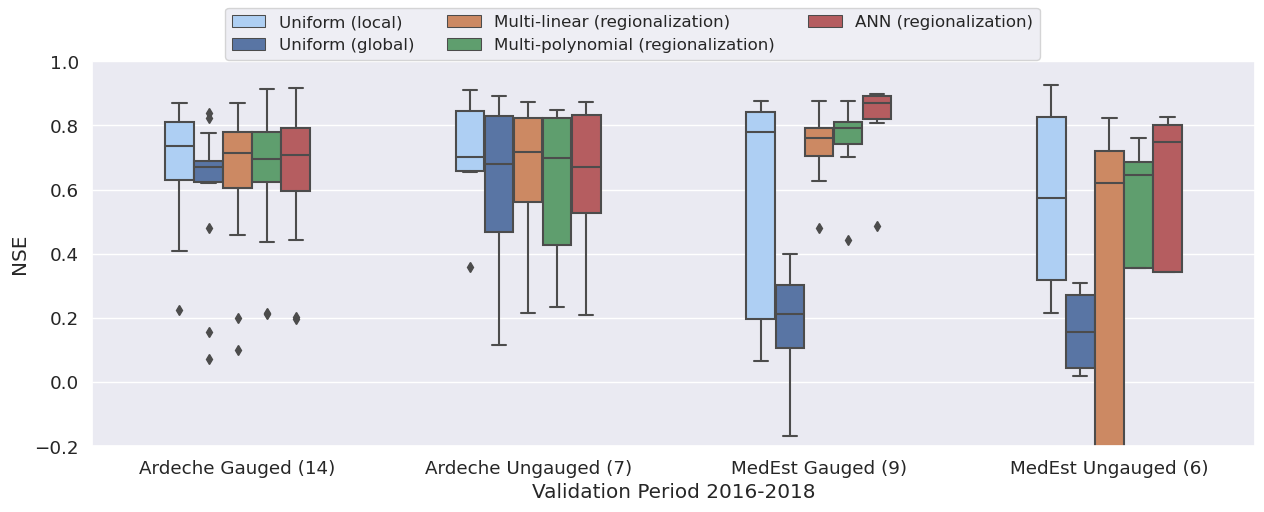

In [39]:
fig, ax = plt.subplots(figsize=(15,5))

sns.boxplot(
        data=dfval,
        x="obs",
        y="NSE",
        hue="method",
        width=0.5,
        palette=colors,
        order=ord,
        showfliers=True,
    )


# Set title and axis labels
ax.set(title=None, xlabel="Validation Period 2016-2018")

ax.set_ylim([-0.2, 1])

handles, labels = ax.get_legend_handles_labels()  # get labels then remove
ax.legend([], [], frameon=False)

# Add legend
fig.legend(
    handles,
    labels,
    title=None,
    loc="upper center",
    ncol=3,
    fontsize=12,
)